In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth
    !pip install bitsandbytes

In [ ]:
import os
os.environ["WANDB_PROJECT"] = 'qwen-ft-code-1024-19March-14b-v2'

In [ ]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arpitkaple13 (arpitkaple13-rbu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",
] # More models at https://huggingface.co/unsloth

qwen_models = [
    "unsloth/Qwen2.5-Coder-32B-Instruct",      # Qwen 2.5 Coder 2x faster
    "unsloth/Qwen2.5-Coder-7B",
    "unsloth/Qwen2.5-14B-Instruct",            # 14B fits in a 16GB card
    "unsloth/Qwen2.5-7B",
    "unsloth/Qwen2.5-72B-Instruct",            # 72B fits in a 48GB card
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen2.5-Coder-14B-Instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.17: Fast Qwen2 patching. Transformers: 4.48.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/210k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.51k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.3.17 patched 48 layers with 48 QKV layers, 48 O layers and 48 MLP layers.


In [ ]:
dataset_path = "/content/drive/MyDrive/arpit_project/qwen_model/dataset_filtered_unsloth/Qwen2-1.5b-bnb-4bit_1024/train"

In [ ]:
from datasets import load_from_disk

EOS_TOKEN = tokenizer.eos_token  # Must add EOS_TOKEN

def formatting_prompts_func(examples):
    old_code = examples["oldf"]
    diff_hunk = examples["patch"]

    def get_resp(y):
        if y == 1:
            return "YES"
        else:
            return "NO"

    response = [get_resp(e) for e in examples['y']]
    texts = []

    for old_c, new_c, label in zip(old_code, diff_hunk, response):
        # Define the role-based messages for Qwen
        messages = [
            {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant. Your task is to evaluate pull request diffs and determine if they require further review by a human."},
            {"role": "user", "content": f"You are given a diff from a pull request, containing some old code, as well as the code written by a developer to replace it.\n\n### Old Code:\n{old_c}\n\n### Proposed Code:\n{new_c}\n\nDetermine if this pull request is likely good to merge or requires the review of another developer.\nOutput only whether it requires a review or not by saying YES or NO. Do NOT output anything else."},
            {"role": "assistant", "content": label}  # Predefined response (YES/NO)
        ]

        # Use Qwen's apply_chat_template method to format the messages
        text = tokenizer.apply_chat_template(messages, tokenize=False) + EOS_TOKEN
        texts.append(text)

    return {"text": texts}

dataset = load_from_disk(dataset_path)
dataset = dataset.map(formatting_prompts_func, batched=True)


Map:   0%|          | 0/36750 [00:00<?, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['oldf', 'patch', 'msg', 'id', 'y', 'idx', 'proj', 'lang', 'text', 'seq_len'],
    num_rows: 36750
})

In [ ]:
dataset[0]["text"]

'<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant. Your task is to evaluate pull request diffs and determine if they require further review by a human.<|im_end|>\n<|im_start|>user\nYou are given a diff from a pull request, containing some old code, as well as the code written by a developer to replace it.\n\n### Old Code:\n\n\n### Proposed Code:\n@@ -0,0 +1,95 @@\n+/*\n+ * Copyright (c) MuleSoft, Inc.  All rights reserved.  http://www.mulesoft.com\n+ * The software in this package is published under the terms of the CPAL v1.0\n+ * license, a copy of which has been included with this distribution in the\n+ * LICENSE.txt file.\n+ */\n+\n+package org.mule.routing;\n+\n+import org.mule.api.DefaultMuleException;\n+import org.mule.api.ExceptionPayload;\n+import org.mule.api.MuleEvent;\n+import org.mule.api.MuleException;\n+import org.mule.api.config.MuleProperties;\n+import org.mule.api.routing.RouterResultsHandler;\n+import org.mule.config.i18n.Message

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 4,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 4, # Fixed major bug in latest Unsloth
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 30,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "paged_adamw_8bit", # Save more memory
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "wandb", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=4):   0%|          | 0/36750 [00:00<?, ? examples/s]

In [ ]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|im_start|>user\n",
    response_part = "<|im_start|>assistant\n",
)

Map (num_proc=2):   0%|          | 0/36750 [00:00<?, ? examples/s]

In [ ]:
tokenizer.decode(trainer.train_dataset[5]["input_ids"])

'<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant. Your task is to evaluate pull request diffs and determine if they require further review by a human.<|im_end|>\n<|im_start|>user\nYou are given a diff from a pull request, containing some old code, as well as the code written by a developer to replace it.\n\n### Old Code:\n\n\n### Proposed Code:\n@@ -0,0 +1,59 @@\n+/*\n+Copyright 2019 The Skaffold Authors\n+\n+Licensed under the Apache License, Version 2.0 (the "License");\n+you may not use this file except in compliance with the License.\n+You may obtain a copy of the License at\n+\n+    http://www.apache.org/licenses/LICENSE-2.0\n+\n+Unless required by applicable law or agreed to in writing, software\n+distributed under the License is distributed on an "AS IS" BASIS,\n+WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n+See the License for the specific language governing permissions and\n+limitations under the License.\n+*

In [ ]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[5]["labels"]])

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             YES<|im_end|>\n<|im_end|>'

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 36,750 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 68,812,800/14,000,000,000 (0.49% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,3.884200
2,3.896700
3,3.824100
4,3.383700
5,2.398200
6,1.117400
7,0.437800
8,0.254700
9,0.159200
10,0.226300


In [ ]:
from datasets import load_from_disk
test_dataset_path = "/content/drive/MyDrive/arpit_project/qwen_model/dataset_filtered_unsloth/Qwen2-1.5b-bnb-4bit_1024/test"
dataset = load_from_disk(test_dataset_path)

In [ ]:
dataset

In [ ]:
old_c = dataset[1]["oldf"]
new_c = dataset[1]["patch"]
gt = dataset[1]["y"]

In [ ]:
gt

In [ ]:
model.save_pretrained("my_model_19_03") # Local saving
tokenizer.save_pretrained("my_model_19_03")

In [ ]:
####### Inference ##########

In [ ]:
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "my_model_19_03", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = 2048,
        dtype = None,
        load_in_4bit = True,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

In [ ]:
from tqdm import tqdm
import csv
import torch
FastLanguageModel.for_inference(model)
with open('review_results.csv', 'w', newline='') as csvfile:
    fieldnames = ['idx', 'id', 'ground_truth', 'model_prediction', 'full_op']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for entry in tqdm(dataset):
        old_c = entry["oldf"]
        new_c = entry["patch"]
        gt    = entry["y"]
        messages = [
            {"role": "user", "content": f"You are given a diff from a pull request, containing some old code, as well as the code written by a developer to replace it.\n\n### Old Code:\n{old_c}\n\n### Proposed Code:\n{new_c}\n\nDetermine if this pull request is likely good to merge or requires the review of another developer.\nOutput only whether it requires a review or not by saying YES or NO. Do NOT output anything else."},
        ]
        inputs = tokenizer.apply_chat_template(
            messages,
            tokenize = True,
            add_generation_prompt = True, # Must add for generation
            return_tensors = "pt",
        ).to("cuda")
        with torch.no_grad():
            outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True,
                                     temperature = 1.5, min_p = 0.1)
            final_output = tokenizer.batch_decode(outputs)[0]
            assistant_start = final_output.find('<|im_start|>assistant\n')
            if assistant_start == -1:
                extracted_output = ""
            else:
                content_start = assistant_start + len('<|im_start|>assistant\n')
                content_end = final_output.find('<|im_end|>', content_start)
                if content_end == -1:
                    extracted_output = final_output[content_start:]
                else:
                    extracted_output = final_output[content_start:content_end]
            writer.writerow({

            'idx': entry["idx"],  # Truncate for readability
            'id': entry["id"],  # Truncate for readability
            'ground_truth': gt,
            'model_prediction': extracted_output,
            'full_op': final_output
        })


100%|██████████| 6023/6023 [10:16<00:00,  9.76it/s]


Confusion Matrix:
[[ 337  541]
 [1109 4036]]
Accuracy: 0.7261
Precision: 0.8818
Recall: 0.7845
F1 Score: 0.8303


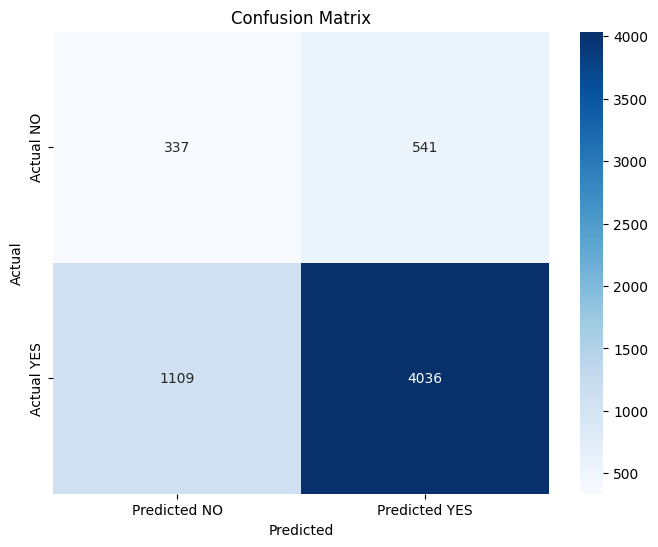


Using sklearn metrics:
Confusion Matrix:
[[ 337  541]
 [1109 4036]]
Accuracy: 0.7261
Precision: 0.8818
Recall: 0.7845
F1 Score: 0.8303


In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Initialize counters
tp = 0  # True Positive: predicted YES when ground truth is 1
tn = 0  # True Negative: predicted NO when ground truth is 0
fp = 0  # False Positive: predicted YES when ground truth is 0
fn = 0  # False Negative: predicted NO when ground truth is 1
total = 0

with open('/content/drive/MyDrive/arpit_project/qwen_original/Qwen_14B/review_results.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    y_true = []
    y_pred = []

    for row in reader:
        total += 1
        gt = row["ground_truth"]
        prediction = row["model_prediction"]

        # Convert to binary format for metrics calculation
        y_true.append(int(gt))
        pred_binary = 1 if "YES" in prediction else 0
        y_pred.append(pred_binary)

        # Count each case
        if "YES" in prediction and gt == "1":
            tp += 1
        elif "NO" in prediction and gt == "0":
            tn += 1
        elif "YES" in prediction and gt == "0":
            fp += 1
        elif "NO" in prediction and gt == "1":
            fn += 1

# Create confusion matrix manually
conf_matrix = np.array([[tn, fp], [fn, tp]])

# Calculate metrics
accuracy = (tp + tn) / total
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted NO', 'Predicted YES'],
            yticklabels=['Actual NO', 'Actual YES'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Alternative: Use sklearn's built-in functions
print("\nUsing sklearn metrics:")
print(f"Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
